<a href="https://colab.research.google.com/github/DralnMatthew/BoneAge/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

In [16]:
from google.colab import drive

In [17]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os
if not os.path.exists("/content/data/project"):
    os.makedirs("/content/data/project")
if not os.path.exists("/content/data/checkpoints"):
    os.makedirs("/content/data/checkpoints")

In [19]:
!unzip /content/drive/MyDrive/Health/archive.zip -d /content/data/project

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4264.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4265.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4266.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4268.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4269.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4270.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4271.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4272.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/4273.png  
  inflating: /content/data/project/boneage-training-dataset/boneage-training-dataset/

In [20]:
!pip install solt

import torch
import pathlib
import random
import cv2
import gc
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import solt as sl
import solt.transforms as slt
import sklearn.model_selection as ms
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

cv2.ocl.setUseOpenCL(False)
cv2.setNumThreads(0)

In [21]:
base_path = pathlib.Path("/content/data/project/")

df = pd.read_csv(base_path / "boneage-training-dataset.csv")
df.drop_duplicates(inplace=True)

df

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False
...,...,...,...
12606,15605,50,False
12607,15606,113,False
12608,15608,55,False
12609,15609,150,True


In [22]:
df["image"] = df.apply(lambda x: f"/content/data/project/boneage-training-dataset/boneage-training-dataset/{x.id}.png", 1)

df.head()

,id,boneage,male,image
0,1377,180,False,/content/data/project/boneage-training-dataset...
1,1378,12,False,/content/data/project/boneage-training-dataset...
2,1379,94,False,/content/data/project/boneage-training-dataset...
3,1380,120,True,/content/data/project/boneage-training-dataset...
4,1381,82,False,/content/data/project/boneage-training-dataset...


In [23]:
df.drop_duplicates(subset=['id'], inplace=True)

df

,id,boneage,male,image
0,1377,180,False,/content/data/project/boneage-training-dataset...
1,1378,12,False,/content/data/project/boneage-training-dataset...
2,1379,94,False,/content/data/project/boneage-training-dataset...
3,1380,120,True,/content/data/project/boneage-training-dataset...
4,1381,82,False,/content/data/project/boneage-training-dataset...
...,...,...,...,...
12606,15605,50,False,/content/data/project/boneage-training-dataset...
12607,15606,113,False,/content/data/project/boneage-training-dataset...
12608,15608,55,False,/content/data/project/boneage-training-dataset...
12609,15609,150,True,/content/data/project/boneage-training-dataset...


In [24]:
mean_boneage = df['boneage'].mean()
std_boneage = df['boneage'].std()
df['boneage_zscore'] = (df['boneage'] - mean_boneage) / std_boneage

df.head()

,id,boneage,male,image,boneage_zscore
0,1377,180,False,/content/data/project/boneage-training-dataset...,1.279181
1,1378,12,False,/content/data/project/boneage-training-dataset...,-2.800269
2,1379,94,False,/content/data/project/boneage-training-dataset...,-0.809109
3,1380,120,True,/content/data/project/boneage-training-dataset...,-0.177766
4,1381,82,False,/content/data/project/boneage-training-dataset...,-1.100498


In [25]:
mean_boneage, std_boneage

(127.3207517246848, 41.18202139939618)

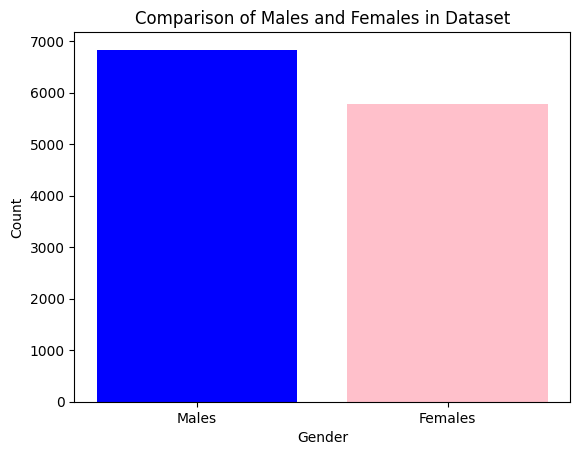

In [26]:
male_count = df["male"].sum()
female_count = len(df) - male_count

labels = ['Males', 'Females']
values = [male_count, female_count]

plt.bar(labels, values, color=['blue', 'pink'])
plt.title('Comparison of Males and Females in Dataset')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.show()

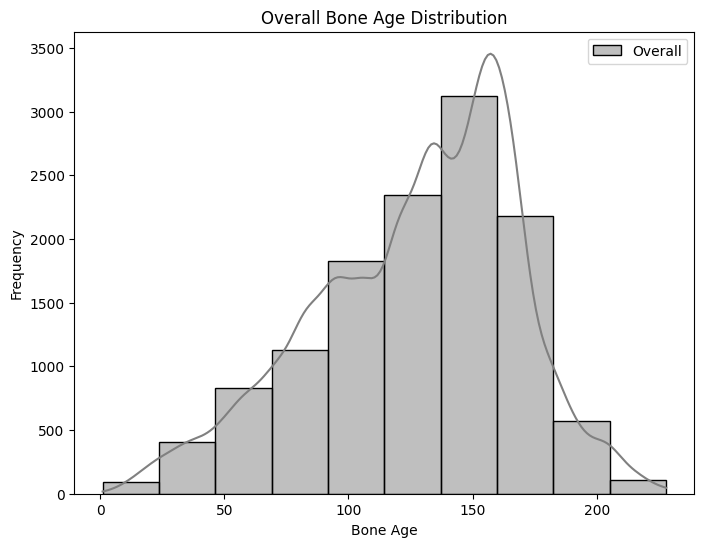

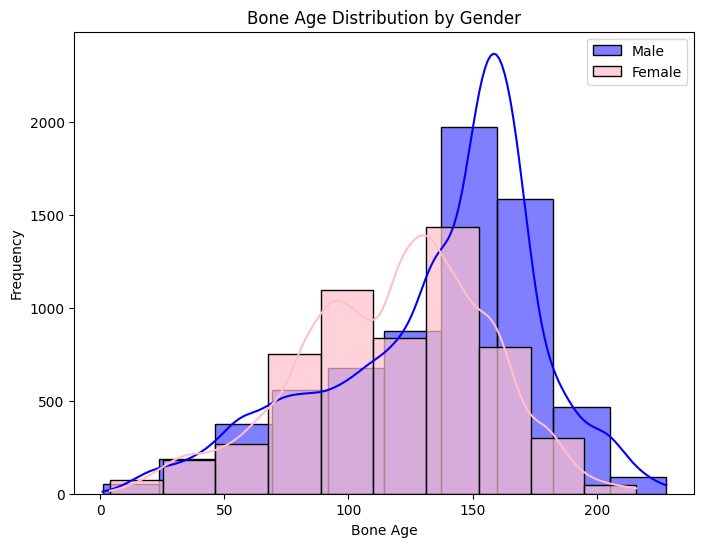

In [27]:
plt.figure(figsize=(8, 6))
sns.histplot(df['boneage'], kde=True, bins=10, color='gray', label='Overall')
plt.title('Overall Bone Age Distribution')
plt.xlabel('Bone Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df[df['male'] == True]['boneage'], kde=True, bins=10, color='blue', label='Male')
sns.histplot(df[df['male'] == False]['boneage'], kde=True, bins=10, color='pink', label='Female', alpha=0.7)
plt.title('Bone Age Distribution by Gender')
plt.xlabel('Bone Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [28]:
# from sklearn.model_selection import StratifiedGroupKFold, GroupKFold

# sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
# gkf = GroupKFold(n_splits=5)

# folds_all = []
# folds_male = []
# folds_female = []

# for train_index, val_index in sgkf.split(df, df['male'], groups=df["id"]):
#     train_split = df.iloc[train_index]
#     val_split = df.iloc[val_index]
#     folds_all.append((train_split, val_split))

# df_male = df[df['male'] == True]
# for train_index, val_index in gkf.split(df_male, groups=df_male["id"]):
#     train_split = df.iloc[train_index]
#     val_split = df.iloc[val_index]
#     folds_male.append((train_split, val_split))

# df_female = df[df['male'] == False]
# for train_index, val_index in gkf.split(df_female, groups=df_female["id"]):
#     train_split = df.iloc[train_index]
#     val_split = df.iloc[val_index]
#     folds_female.append((train_split, val_split))

df_train, df_test = train_test_split(df, test_size=0.3, random_state=SEED, stratify=df.male)

df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=SEED, stratify=df_train.male)

In [30]:
class BoneAgeDataset(Dataset):
    def __init__(self, ds, augs):
        self.ds = ds
        self.augs = augs

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        sample = self.ds.iloc[idx]
        img = cv2.imread(sample['image'])

        male = torch.tensor(1 if sample['male'] else 0, dtype=torch.float32)
        boneage = torch.tensor(sample['boneage_zscore'], dtype=torch.float32)
        if self.augs:
            img = self.augs(img, normalize=False, return_torch=False).data[0]

        img = torch.FloatTensor(img.copy().transpose(2, 0, 1))

        return {'image': img, 'boneage': boneage, 'isMale': male}

In [5]:
import solt.core as slc
import solt.transforms as slt

train_aug = slc.Stream([
    slt.Brightness(brightness_range=(-77, 77), p=1),
    slt.Contrast(contrast_range=(0.7, 1.3), p=1),
    slt.Rotate(angle_range=(-15, 15), padding='r', p=1),
    slt.GammaCorrection(gamma_range=(0.5, 2.5), p=1),
    slt.Resize(resize_to=(224, 224))
])

val_aug = slc.Stream([
    slt.Resize(resize_to=(224, 224))
])

In [15]:
train_ds_tmp = BoneAgeDataset(df_train, train_aug)
train_ds_tmp[0]['image']

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

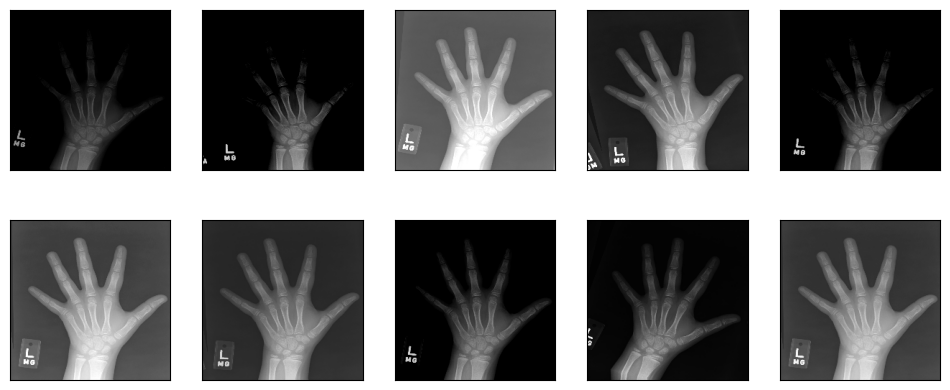

In [16]:
n_runs = 5
plt.figure(figsize=(12, 5))

for i in range(n_runs):
    plt.subplot(2, n_runs, i*2 + 1)
    img = cv2.imread(df_train.iloc[0].image)
    img_trf = train_aug(img, normalize=False, return_torch=False).data[0]
    plt.imshow(img_trf)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, n_runs, i*2 + 2)
    img = cv2.imread(df_train.iloc[0].image)
    img_trf = train_aug(img, normalize=False, return_torch=False).data[0]
    plt.imshow(img_trf)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [17]:
train_loader_tmp = DataLoader(train_ds_tmp, batch_size=32, num_workers=2)

for i, batch in enumerate(train_loader_tmp):
    print(batch['image'].size(), batch['boneage'].size())
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [18]:
!pip install torchvision

In [6]:
from torchvision import models

class AlexNetRegressor(nn.Module):
    def __init__(self, dropout=0.5, use_gender=True):
        super(AlexNetRegressor, self).__init__()

        self.use_gender = use_gender
        self.base_model = models.alexnet(weights = models.AlexNet_Weights.IMAGENET1K_V1)

        for param in self.base_model.features.parameters():
            param.requires_grad = False

        if use_gender:
            self.base_model.classifier[-1] = nn.Linear(self.base_model.classifier[-1].in_features, self.base_model.classifier[-1].in_features)
            self.gender_fc = nn.Sequential(
                nn.Linear(1, 16),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.final_fc = nn.Sequential(
                nn.Linear(self.base_model.classifier[-1].out_features + 16, 256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(256, 1)
            )
        else:
            self.base_model.classifier[-1] = nn.Linear(self.base_model.classifier[-1].in_features, 1)

    def forward(self, x, gender=None):
        if self.use_gender and gender is not None:
            x = self.base_model(x)
            # print(1, x.shape)
            gender = gender.unsqueeze(1)
            gender = self.gender_fc(gender)
            # print(2, gender.shape)
            x = torch.cat([x, gender], dim=1)
            # print(3, x.shape)
            x = self.final_fc(x)
            # print(4, x.shape)
            return x

        else:
            x = self.base_model(x)
            return x

class ResNetRegressor(nn.Module):
    def __init__(self, dropout=0.5, use_gender=True):
        super(ResNetRegressor, self).__init__()

        self.use_gender = use_gender
        self.base_model = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V1)

        for param in self.base_model.parameters():
            param.requires_grad = False
        for param in self.base_model.fc.parameters():
            param.requires_grad = True

        if use_gender:
            self.base_model.fc = nn.Linear(self.base_model.fc.in_features, self.base_model.fc.in_features)
            self.gender_fc = nn.Sequential(
                nn.Linear(1, 16),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
            self.final_fc = nn.Sequential(
                nn.Linear(self.base_model.fc.out_features + 16, 256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(256, 256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(256, 1)
            )
        else:
            self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)

    def forward(self, x, gender=None):
        if self.use_gender and gender is not None:
            x = self.base_model(x)
            gender = gender.unsqueeze(1)
            gender = self.gender_fc(gender)
            x = torch.cat([x, gender], dim=1)
            x = self.final_fc(x)
            return x

        else:
            x = self.base_model(x)
            return x


In [34]:
import torch
import time
import os
import gc
import pathlib
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


class Trainer:
    def __init__(self, train_df, val_df, cfg, model_name = "alexnet", use_gender=True):
        self.train_df = train_df
        self.val_df = val_df
        self.cfg = cfg

        self.train_loader = None
        self.val_loader = None
        self.loss_fn = None
        self.optimizer = None
        self.model = None
        self.best_metric = float('inf')
        self.best_epoch = 0
        self.best_model_path = ""

        self.model_name = model_name
        self.use_gender = use_gender

    def init_model(self):
        if hasattr(self, "model"):
            del self.model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()

        if self.model_name == "alexnet":
            self.model = AlexNetRegressor(dropout=self.cfg.dropout, use_gender=self.use_gender)
        elif self.model_name == "resnet":
            self.model = ResNetRegressor(dropout=self.cfg.dropout, use_gender=self.use_gender)

        self.model = self.model.to(self.cfg.device)

    def init_run(self):
        del self.train_loader
        del self.val_loader
        del self.optimizer
        gc.collect()
        torch.cuda.empty_cache()

        self.init_model()

        train_ds = BoneAgeDataset(self.train_df, self.cfg.train_aug)
        val_ds = BoneAgeDataset(self.val_df, self.cfg.val_aug)

        self.train_loader = DataLoader(train_ds, batch_size=self.cfg.batch_size, shuffle=True, num_workers=self.cfg.n_workers)
        self.val_loader = DataLoader(val_ds, batch_size=self.cfg.batch_size, num_workers=self.cfg.n_workers)

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.cfg.lr, weight_decay=self.cfg.wd)

        self.loss_fn = nn.MSELoss()

    def run(self, n_epochs=None):
        self.init_run()
        if n_epochs is None:
            n_epochs = self.cfg.num_epochs

        self.history = {"train_loss": [], "val_loss": []}

        for self.epoch in range(n_epochs):
            time0 = time.time()

            self.model.train()
            train_loss = self.train_epoch()
            self.history["train_loss"].append(train_loss)

            self.model.eval()
            val_loss, preds_val, gt_val, mae, mse = self.val_epoch()
            self.history["val_loss"].append(val_loss)

            print(
                f"epoch:{self.epoch + 1}",
                "\ttrain_loss:",
                round(train_loss, 4),
                "\tvalidation_loss:",
                round(val_loss, 4),
                "\tMAE:",
                round(mae, 4),
                "\tMSE:",
                round(mse, 4),
                "\tUsed_time:",
                round((time.time()-time0) / 60, 3)
            )

            if val_loss < self.best_metric:
                self.best_metric = val_loss
                self.best_epoch = self.epoch

                checkpoint_filename = f"Model_{self.model_name}use_gender_{self.use_gender}_epoch_{self.epoch}_best_loss_{self.best_metric:.4f}.pth"
                self.best_model_path = os.path.join(self.cfg.checkpoint_dir, checkpoint_filename)



            sys.stderr.flush()
            # print("=" * 50)
            # print(f"[{self.epoch}] --> Train loss : {train_loss:.4f}")
            # print(f"[{self.epoch}] --> Validation loss : {val_loss:.4f}")
            # print("=" * 50)

        torch.save(self.model.state_dict(), self.best_model_path)
        self.plot_loss_curves()
        print(f"Best model saved at {self.best_model_path}")

    def pass_batch(self, batch):
        img = batch['image'].to(self.cfg.device)
        target = batch['boneage'].to(self.cfg.device)
        gender = batch['isMale'].to(self.cfg.device)

        # print(f"Image shape: {img.shape}, Target shape: {target.shape}")
        if self.use_gender:
            output = self.model(img, gender)
        else:
            output = self.model(img)
        # print(f"Output shape: {output.shape}")
        loss = self.loss_fn(output.squeeze(), target)
        return loss, output

    def train_epoch(self):
        sys.stderr.flush()
        pbar = tqdm(total=len(self.train_loader), position=0, leave=True)
        running_loss = 0.0

        for i, batch in enumerate(self.train_loader):
            self.optimizer.zero_grad()
            loss, _ = self.pass_batch(batch)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            # pbar.set_description(f'Train loss: {running_loss / (i + 1):.4f}')
            pbar.update()

        pbar.close()

        return running_loss / len(self.train_loader)

    def val_epoch(self):
        preds = []
        gt = []
        running_loss = 0.0
        sys.stderr.flush()

        with torch.no_grad():
            # pbar = tqdm(total=len(self.val_loader), desc=f"Validation epoch {self.epoch}", position=0, leave=True)
            pbar = tqdm(total=len(self.val_loader), position=0, leave=True)
            for i, batch in enumerate(self.val_loader):
                loss, output = self.pass_batch(batch)

                running_loss += loss.item()

                preds.append(output.cpu().numpy())
                gt.append(batch['boneage'].numpy())

                pbar.update()

            pbar.close()

        preds = np.concatenate(preds)
        gt = np.concatenate(gt)

        val_loss = running_loss / len(self.val_loader)
        mae = mean_absolute_error(gt, preds)
        mse = mean_squared_error(gt, preds)

        # print(f"Validation MAE: {mae:.4f}, MSE: {mse:.4f}")

        return val_loss, preds, gt, mae, mse

    def plot_loss_curves(self):
        plt.figure(figsize=(12, 6))

        plt.plot(self.history["train_loss"], label="Training Loss", marker='o')
        plt.plot(self.history["val_loss"], label="Validation Loss", marker='o')
        plt.yscale('log')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss Curves")
        plt.legend()
        plt.grid()

In [8]:
class Cfg:
    device = torch.device("cuda:0")
    bw = 32
    dropout = 0.5
    wd = 1e-3
    lr = 1e-4
    num_epochs = 15
    n_workers = 2
    batch_size = 16
    train_aug = train_aug
    val_aug = val_aug
    best_model_path = ""
    lr_drop_milestones = [10000, ]
    seed = 42
    checkpoint_dir = pathlib.Path("/content/drive/MyDrive/Health")

In [9]:
cfg = Cfg()

100%|██████████| 111/111 [00:46<00:00,  2.37it/s]


epoch:1 	train_loss: 9.2385 	validation_loss: 0.9661 	MAE: 0.7764 	MSE: 0.9691 	Used_time: 8.947


100%|██████████| 111/111 [00:48<00:00,  2.31it/s]


epoch:2 	train_loss: 1.3009 	validation_loss: 0.8625 	MAE: 0.7552 	MSE: 0.8647 	Used_time: 8.96


100%|██████████| 111/111 [00:47<00:00,  2.31it/s]


epoch:3 	train_loss: 0.9647 	validation_loss: 0.8162 	MAE: 0.7079 	MSE: 0.8162 	Used_time: 8.908


100%|██████████| 111/111 [00:47<00:00,  2.33it/s]


epoch:4 	train_loss: 0.8831 	validation_loss: 0.6814 	MAE: 0.6716 	MSE: 0.6833 	Used_time: 8.892


100%|██████████| 111/111 [00:47<00:00,  2.32it/s]


epoch:5 	train_loss: 0.855 	validation_loss: 0.6813 	MAE: 0.6746 	MSE: 0.683 	Used_time: 9.042


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


epoch:6 	train_loss: 0.8106 	validation_loss: 0.6348 	MAE: 0.6213 	MSE: 0.6349 	Used_time: 8.982


100%|██████████| 111/111 [00:47<00:00,  2.35it/s]


epoch:7 	train_loss: 0.8035 	validation_loss: 0.6135 	MAE: 0.6288 	MSE: 0.615 	Used_time: 9.002


100%|██████████| 111/111 [00:46<00:00,  2.37it/s]


epoch:8 	train_loss: 0.764 	validation_loss: 0.5998 	MAE: 0.613 	MSE: 0.6008 	Used_time: 8.912


100%|██████████| 111/111 [00:47<00:00,  2.34it/s]


epoch:9 	train_loss: 0.7691 	validation_loss: 0.6044 	MAE: 0.6141 	MSE: 0.6055 	Used_time: 8.828


100%|██████████| 111/111 [00:47<00:00,  2.33it/s]


epoch:10 	train_loss: 0.7536 	validation_loss: 0.595 	MAE: 0.604 	MSE: 0.5951 	Used_time: 8.834


100%|██████████| 111/111 [00:47<00:00,  2.34it/s]


epoch:11 	train_loss: 0.755 	validation_loss: 0.5785 	MAE: 0.5951 	MSE: 0.5789 	Used_time: 8.841


100%|██████████| 111/111 [00:47<00:00,  2.32it/s]


epoch:12 	train_loss: 0.7309 	validation_loss: 0.5528 	MAE: 0.577 	MSE: 0.5526 	Used_time: 8.789


100%|██████████| 111/111 [00:47<00:00,  2.32it/s]


epoch:13 	train_loss: 0.7529 	validation_loss: 0.5887 	MAE: 0.6177 	MSE: 0.5903 	Used_time: 8.831


100%|██████████| 111/111 [00:47<00:00,  2.32it/s]


epoch:14 	train_loss: 0.7345 	validation_loss: 0.5644 	MAE: 0.5902 	MSE: 0.565 	Used_time: 8.867


100%|██████████| 111/111 [00:47<00:00,  2.32it/s]


epoch:15 	train_loss: 0.7264 	validation_loss: 0.5618 	MAE: 0.5765 	MSE: 0.5619 	Used_time: 8.831
Best model saved at /content/drive/MyDrive/Health/Model_alexnet_epoch_11_best_loss_0.5528.pth


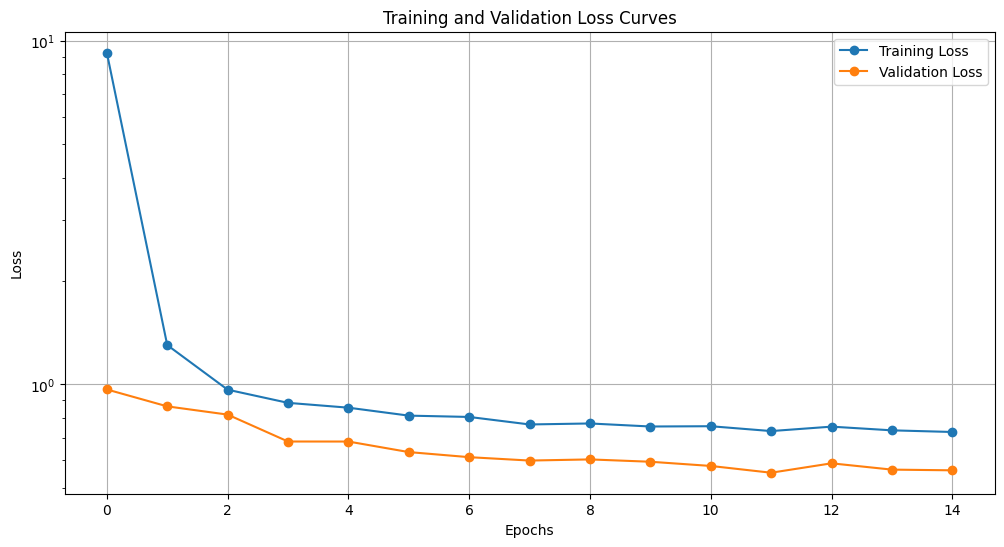

In [ ]:
trainer1 = Trainer(df_train, df_val, cfg, model_name = "alexnet", use_gender=False)
trainer1.run()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 92.8MB/s]
100%|██████████| 111/111 [00:47<00:00,  2.32it/s]


epoch:1 	train_loss: 0.8308 	validation_loss: 0.6796 	MAE: 0.6835 	MSE: 0.6815 	Used_time: 9.273


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


epoch:2 	train_loss: 0.6642 	validation_loss: 0.5799 	MAE: 0.6209 	MSE: 0.5814 	Used_time: 9.032


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


epoch:3 	train_loss: 0.6162 	validation_loss: 0.5322 	MAE: 0.5884 	MSE: 0.5339 	Used_time: 9.042


100%|██████████| 111/111 [00:47<00:00,  2.33it/s]


epoch:4 	train_loss: 0.5853 	validation_loss: 0.5736 	MAE: 0.6069 	MSE: 0.5757 	Used_time: 8.953


100%|██████████| 111/111 [00:47<00:00,  2.35it/s]


epoch:5 	train_loss: 0.5627 	validation_loss: 0.4644 	MAE: 0.5409 	MSE: 0.4659 	Used_time: 9.037


100%|██████████| 111/111 [00:44<00:00,  2.47it/s]


epoch:6 	train_loss: 0.5501 	validation_loss: 0.4912 	MAE: 0.5559 	MSE: 0.493 	Used_time: 8.926


100%|██████████| 111/111 [00:47<00:00,  2.34it/s]


epoch:7 	train_loss: 0.548 	validation_loss: 0.4735 	MAE: 0.543 	MSE: 0.4749 	Used_time: 9.181


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


epoch:8 	train_loss: 0.5471 	validation_loss: 0.4623 	MAE: 0.5376 	MSE: 0.4639 	Used_time: 8.96


100%|██████████| 111/111 [00:47<00:00,  2.34it/s]


epoch:9 	train_loss: 0.553 	validation_loss: 0.4442 	MAE: 0.5232 	MSE: 0.4452 	Used_time: 8.864


100%|██████████| 111/111 [00:46<00:00,  2.37it/s]


epoch:10 	train_loss: 0.537 	validation_loss: 0.488 	MAE: 0.5522 	MSE: 0.4898 	Used_time: 8.91


100%|██████████| 111/111 [00:44<00:00,  2.51it/s]


epoch:11 	train_loss: 0.5285 	validation_loss: 0.4395 	MAE: 0.5201 	MSE: 0.4404 	Used_time: 8.8


100%|██████████| 111/111 [00:46<00:00,  2.38it/s]


epoch:12 	train_loss: 0.5401 	validation_loss: 0.4723 	MAE: 0.5436 	MSE: 0.474 	Used_time: 8.82


100%|██████████| 111/111 [00:47<00:00,  2.33it/s]


epoch:13 	train_loss: 0.5424 	validation_loss: 0.4669 	MAE: 0.5391 	MSE: 0.4688 	Used_time: 8.795


100%|██████████| 111/111 [00:44<00:00,  2.50it/s]


epoch:14 	train_loss: 0.5232 	validation_loss: 0.4446 	MAE: 0.5246 	MSE: 0.4462 	Used_time: 8.896


100%|██████████| 111/111 [00:45<00:00,  2.43it/s]


epoch:15 	train_loss: 0.5233 	validation_loss: 0.5061 	MAE: 0.5648 	MSE: 0.5082 	Used_time: 8.75
Best model saved at /content/drive/MyDrive/Health/Model_resnet_epoch_10_best_loss_0.4395.pth


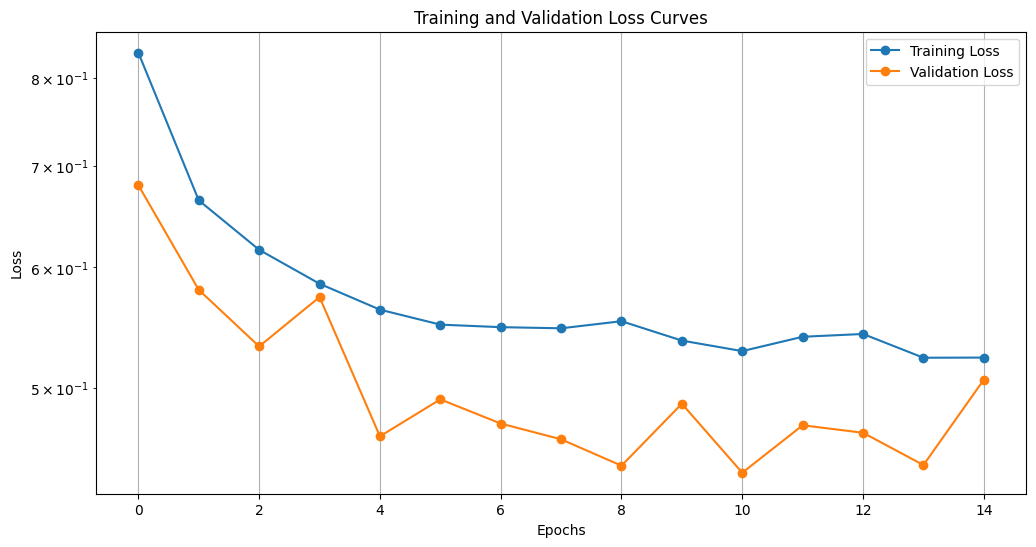

In [ ]:
trainer2 = Trainer(df_train, df_val, cfg, model_name = "resnet", use_gender=False)
trainer2.run()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


epoch:1 	train_loss: 0.8272 	validation_loss: 0.5368 	MAE: 0.5873 	MSE: 0.538 	Used_time: 9.01


100%|██████████| 111/111 [00:49<00:00,  2.23it/s]


epoch:2 	train_loss: 0.6367 	validation_loss: 0.4689 	MAE: 0.5439 	MSE: 0.4704 	Used_time: 9.024


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


epoch:3 	train_loss: 0.5997 	validation_loss: 0.5844 	MAE: 0.6134 	MSE: 0.5864 	Used_time: 9.024


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


epoch:4 	train_loss: 0.557 	validation_loss: 0.4866 	MAE: 0.5479 	MSE: 0.4871 	Used_time: 8.968


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


epoch:5 	train_loss: 0.5611 	validation_loss: 0.4373 	MAE: 0.5234 	MSE: 0.4387 	Used_time: 8.972


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


epoch:6 	train_loss: 0.541 	validation_loss: 0.5649 	MAE: 0.6074 	MSE: 0.5659 	Used_time: 8.95


100%|██████████| 111/111 [00:48<00:00,  2.27it/s]


epoch:7 	train_loss: 0.5369 	validation_loss: 0.3852 	MAE: 0.4732 	MSE: 0.3858 	Used_time: 8.885


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


epoch:8 	train_loss: 0.5196 	validation_loss: 0.4296 	MAE: 0.5274 	MSE: 0.4308 	Used_time: 8.868


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


epoch:9 	train_loss: 0.5243 	validation_loss: 0.3714 	MAE: 0.4766 	MSE: 0.3724 	Used_time: 8.913


100%|██████████| 111/111 [00:48<00:00,  2.28it/s]


epoch:10 	train_loss: 0.5072 	validation_loss: 0.464 	MAE: 0.5522 	MSE: 0.4658 	Used_time: 8.921


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


epoch:11 	train_loss: 0.4958 	validation_loss: 0.3999 	MAE: 0.4773 	MSE: 0.3995 	Used_time: 8.897


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


epoch:12 	train_loss: 0.4789 	validation_loss: 0.3587 	MAE: 0.4628 	MSE: 0.3591 	Used_time: 8.927


100%|██████████| 111/111 [00:49<00:00,  2.26it/s]


epoch:13 	train_loss: 0.4831 	validation_loss: 0.3525 	MAE: 0.4564 	MSE: 0.3524 	Used_time: 8.955


100%|██████████| 111/111 [00:49<00:00,  2.25it/s]


epoch:14 	train_loss: 0.4904 	validation_loss: 0.4297 	MAE: 0.5063 	MSE: 0.4313 	Used_time: 8.904


100%|██████████| 111/111 [00:48<00:00,  2.29it/s]


epoch:15 	train_loss: 0.4824 	validation_loss: 0.377 	MAE: 0.483 	MSE: 0.3777 	Used_time: 8.946
Best model saved at /content/drive/MyDrive/Health/Model_resnet_epoch_12_best_loss_0.3525.pth


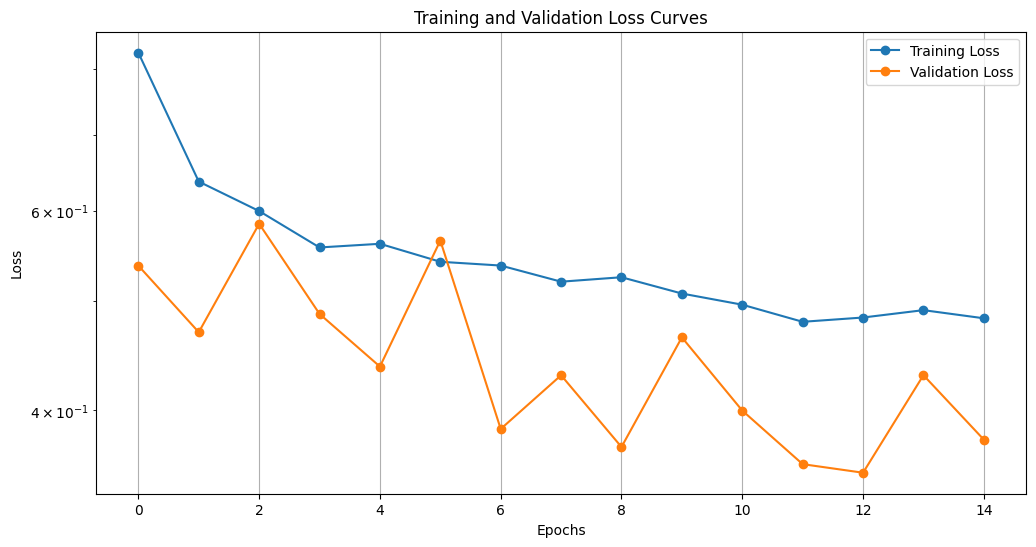

In [ ]:
trainer3 = Trainer(df_train, df_val, cfg, model_name = "resnet", use_gender=True)
trainer3.run()

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [10]:
model1 = AlexNetRegressor(dropout=cfg.dropout, use_gender=False)
model1.load_state_dict(torch.load("/content/drive/MyDrive/Health/Model_alexnet_epoch_11_best_loss_0.5528.pth", map_location=cfg.device))
model1.eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 167MB/s]
<ipython-input-10-921c6cd4794b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the lo

AlexNetRegressor(
  (base_model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=Fa

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [11]:
model2 = ResNetRegressor(dropout=cfg.dropout, use_gender=False)
model2.load_state_dict(torch.load("/content/drive/MyDrive/Health/Model_resnet_epoch_10_best_loss_0.4395.pth", map_location=cfg.device))
model2.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]
<ipython-input-11-3d00267ca733>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

ResNetRegressor(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [12]:
model3 = ResNetRegressor(dropout=cfg.dropout, use_gender=True)
model3.load_state_dict(torch.load("/content/drive/MyDrive/Health/Model_resnet_epoch_12_best_loss_0.3525.pth", map_location=cfg.device))
model3.eval()

<ipython-input-12-82584df4596b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load("/content/drive/MyDrive/Health/Model_resnet_epoch_12_best_

ResNetRegressor(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [13]:
def evaluate_model(model, test_df, cfg, use_gender=False):
    model = model.to('cuda')
    test_ds = BoneAgeDataset(test_df, cfg.val_aug)
    test_loader = DataLoader(test_ds, batch_size=cfg.batch_size, num_workers=cfg.n_workers)

    preds = []
    gt = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            img = batch['image'].to(cfg.device)
            target = batch['boneage'].to(cfg.device)
            gt.extend(target.cpu().numpy())

            if use_gender:
                gender = batch['isMale'].to(cfg.device)
                output = model(img, gender)
            else:
                output = model(img)

            preds.extend(output.cpu().numpy().squeeze())

    preds = np.array(preds)
    gt = np.array(gt)

    mae = mean_absolute_error(gt, preds)
    mse = mean_squared_error(gt, preds)


    np.random.seed(SEED)

    indices = np.random.choice(test_df.shape[0], size=10, replace=False)
    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        img = test_df.iloc[idx]['image']
        img = plt.imread(img)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        ground_truth = gt[idx] * std_boneage + mean_boneage
        prediction = preds[idx] * std_boneage + mean_boneage
        plt.title(f"ID: {test_df.iloc[idx]['id']}\nGT: {ground_truth}\nPred: {prediction:.1f}")

    plt.tight_layout()
    plt.show()
    return preds, gt, mae, mse

In [14]:
def bootstrap_testing(model1, use_gender1, model2, use_gender2):
    # refer to https://medium.com/data-science-at-microsoft/how-to-leverage-permutation-tests-and-bootstrap-tests-for-baselining-your-machine-learning-models-f1010bf22e71
    preds1, gt1, mae1, mse1 = evaluate_model(model1, df_test, cfg, use_gender=use_gender1)
    preds2, gt2, mae2, mse2 = evaluate_model(model2, df_test, cfg, use_gender=use_gender2)

    n_bootstrapped_samples = 1000
    n_samples = df_test.shape[0]
    cnt = 0

    for i in range(n_bootstrapped_samples):
        bootstrap_indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
        gt_bootstrap1 = gt1[bootstrap_indices]
        gt_bootstrap2 = gt2[bootstrap_indices]
        preds_bootstrap1 = preds1[bootstrap_indices]
        preds_bootstrap2 = preds2[bootstrap_indices]
        mse_bootstrap1 = mean_squared_error(gt_bootstrap1, preds_bootstrap1)
        mse_bootstrap2 = mean_squared_error(gt_bootstrap2, preds_bootstrap2)
        if mse_bootstrap1 > mse_bootstrap2:
            cnt += 1

    p_value = 1 - cnt / n_bootstrapped_samples
    print(f"P-value: {p_value:.4f}")
    print(f"MAE1: {mae1:.4f}, MSE1: {mse1:.4f}")
    print(f"MAE2: {mae2:.4f}, MSE2: {mse2:.4f}")

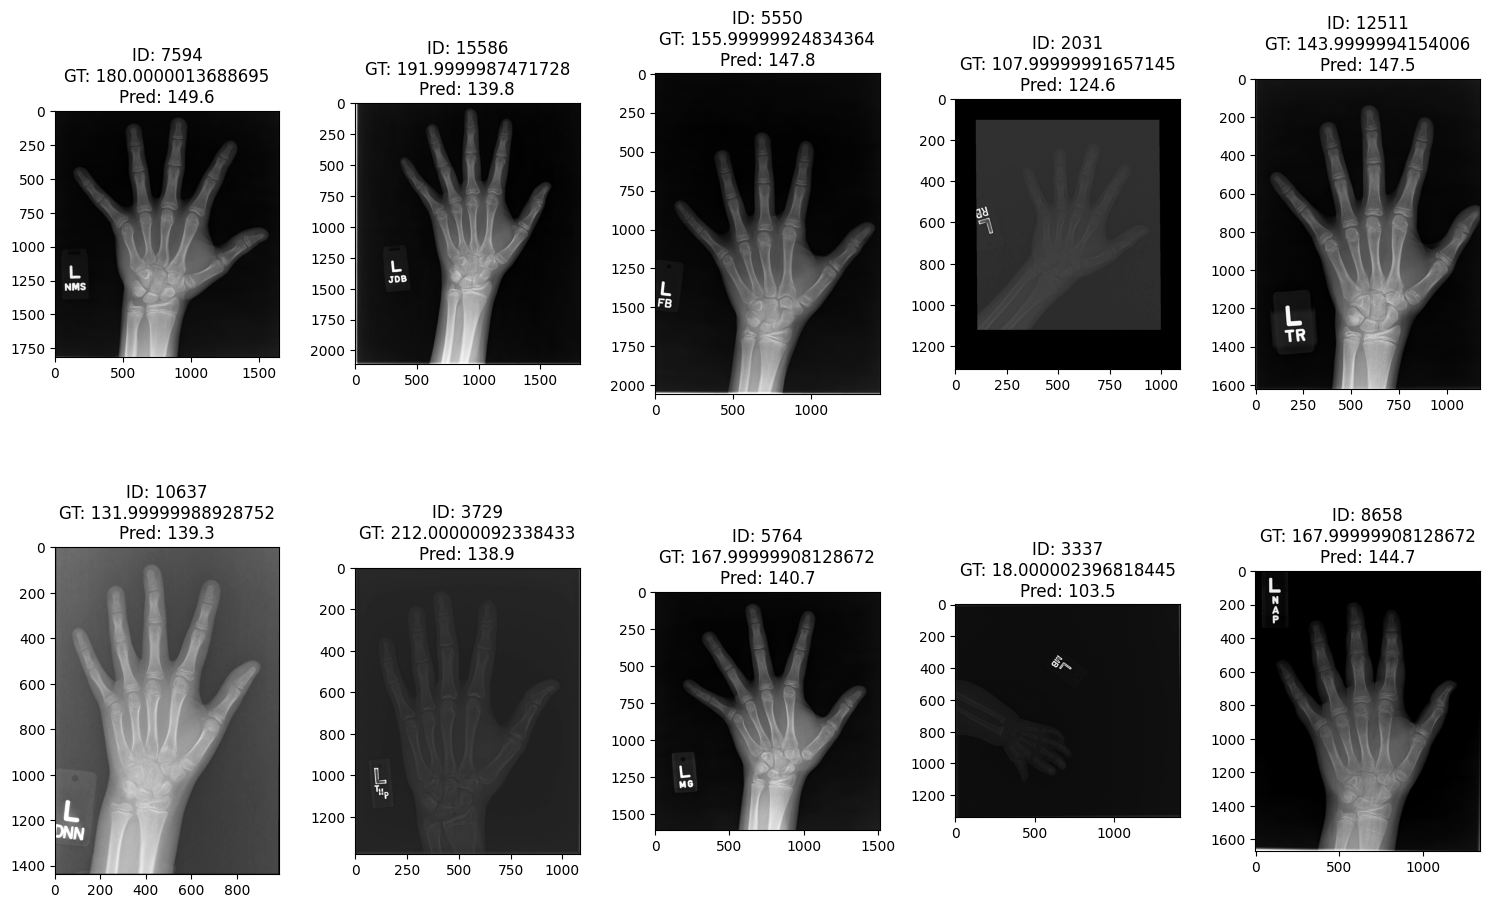

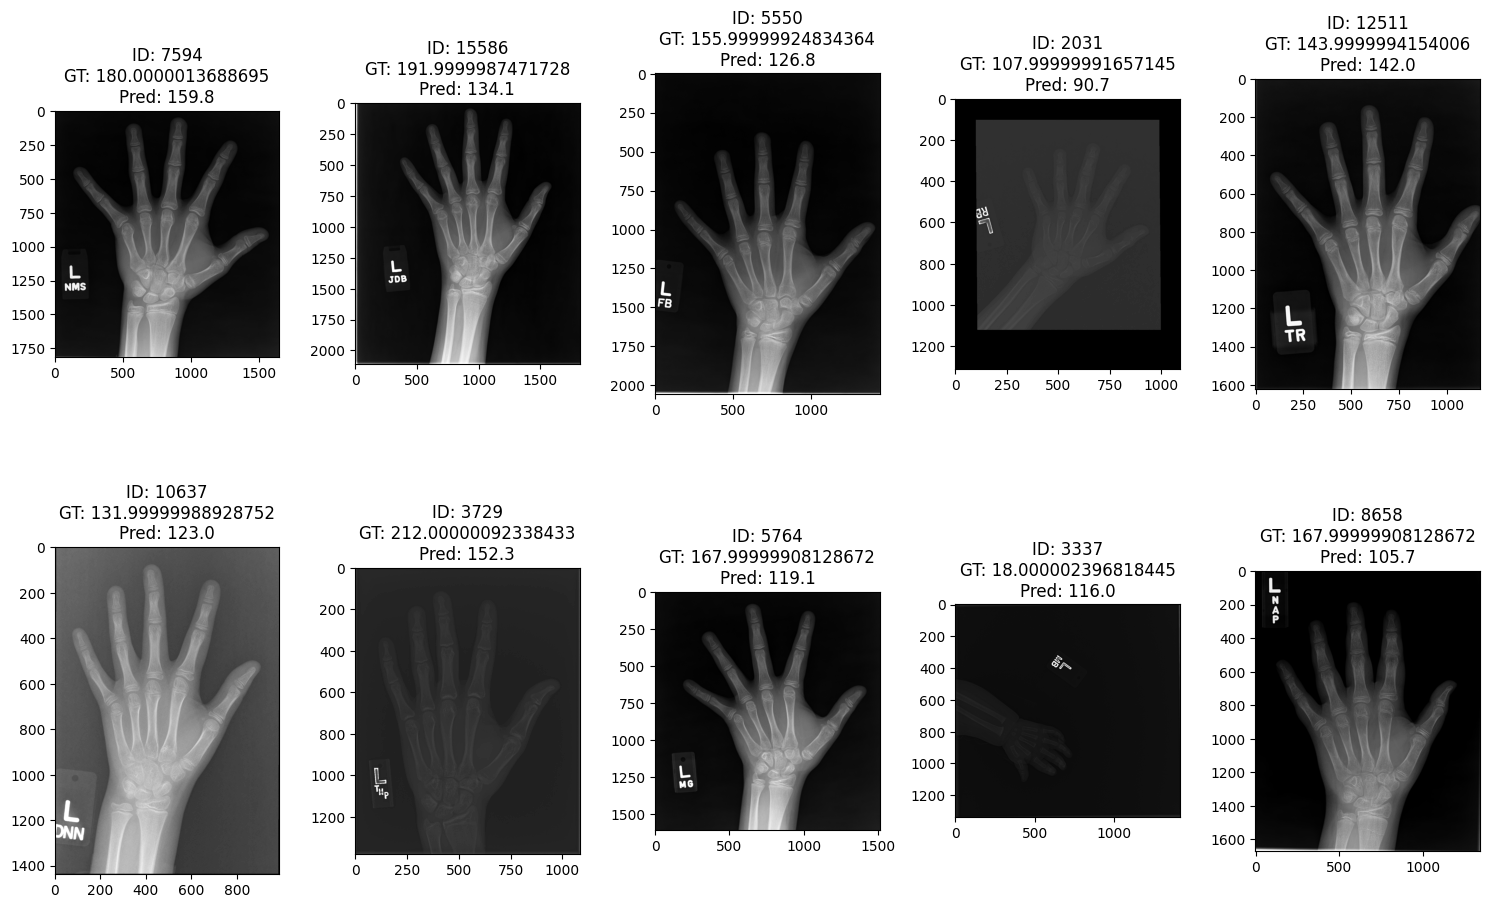

P-value: 0.0000
MAE1: 0.5935, MSE1: 0.5771
MAE2: 0.5769, MSE2: 0.5132


In [35]:
bootstrap_testing(model1, False, model2, False)

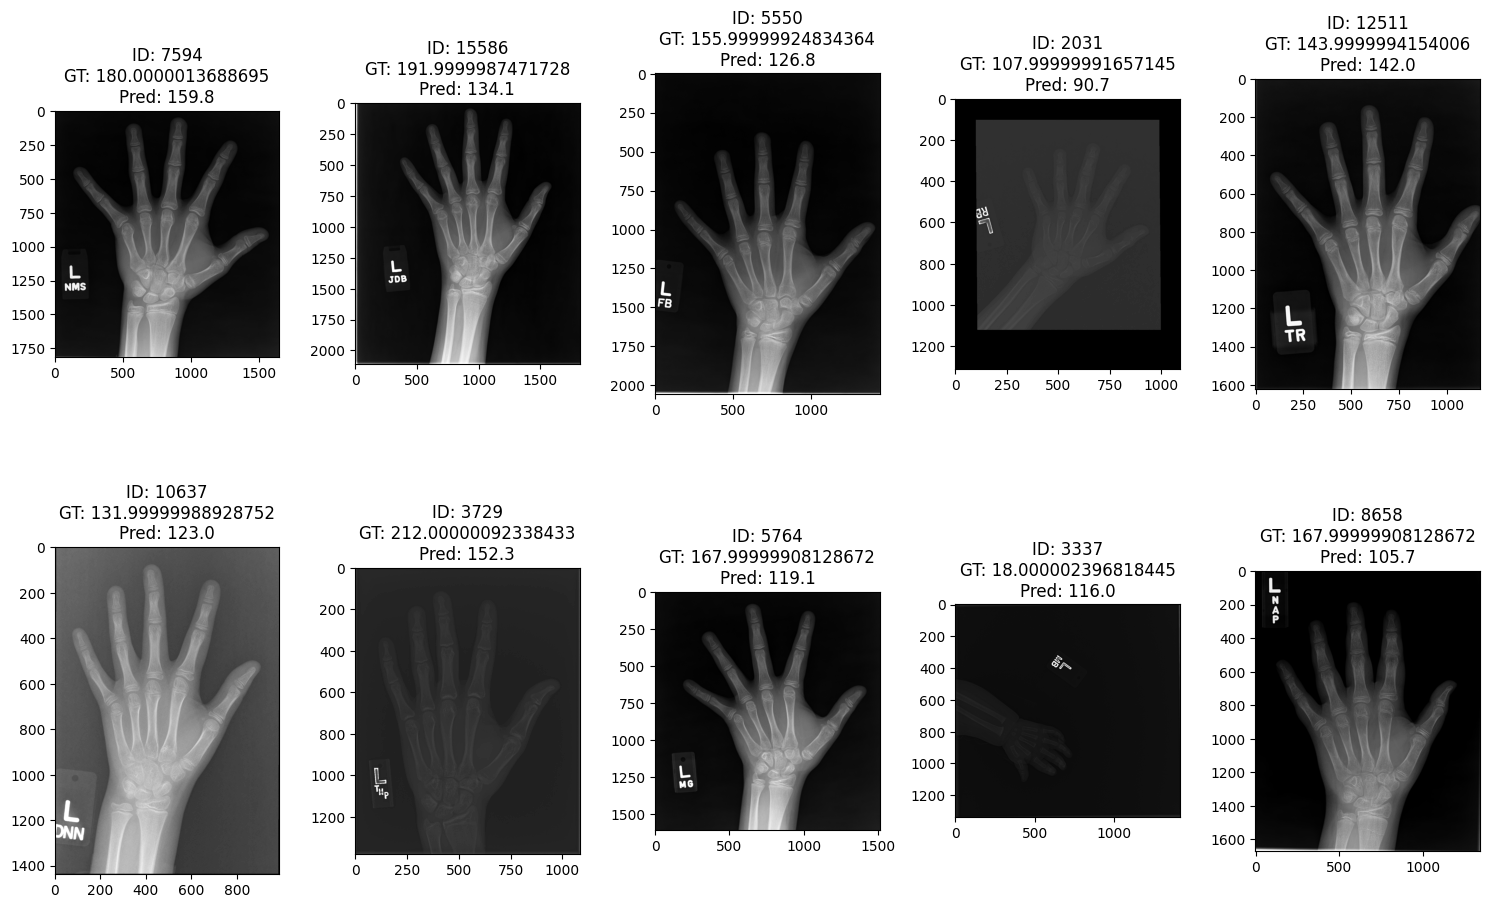

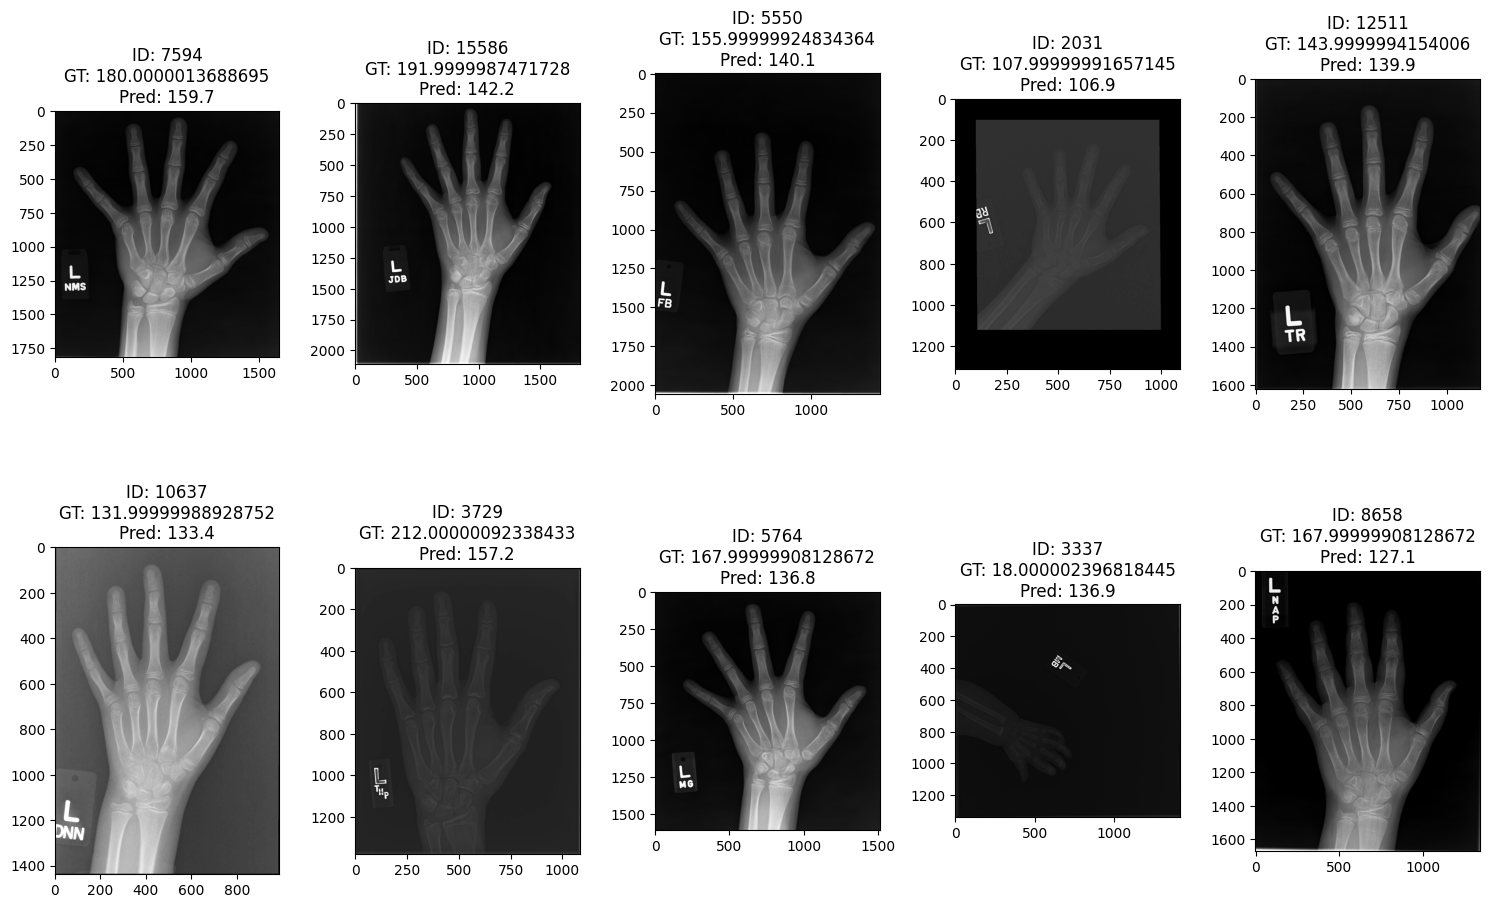

P-value: 0.0000
MAE1: 0.5769, MSE1: 0.5132
MAE2: 0.4862, MSE2: 0.3763


In [36]:
bootstrap_testing(model2, False, model3, True)